In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
trader_df = pd.read_csv('/content/historical_data.csv')
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Data Preprocessing



In [4]:
# Check for missing values
print("Missing values in sentiment_df:")
print(sentiment_df.isnull().sum())

print("\nMissing values in trader_df:")
print(trader_df.isnull().sum())


Missing values in sentiment_df:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in trader_df:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64


In [5]:
# Outlier detection and handling (Removing outliers using IQR for 'Closed PnL' in trader_df)
Q1_pnl = trader_df['Closed PnL'].quantile(0.25)
Q3_pnl = trader_df['Closed PnL'].quantile(0.75)
IQR_pnl = Q3_pnl - Q1_pnl

lower_bound_pnl = Q1_pnl - 1.5 * IQR_pnl
upper_bound_pnl = Q3_pnl + 1.5 * IQR_pnl

outliers_count_pnl = trader_df[(trader_df['Closed PnL'] < lower_bound_pnl) | (trader_df['Closed PnL'] > upper_bound_pnl)].shape[0]
print(f"\nNumber of outliers in 'Closed PnL' before handling: {outliers_count_pnl}")




Number of outliers in 'Closed PnL' before handling: 1155


In [6]:
# Remove outliers from trader_df based on 'Closed PnL'
trader_df_cleaned = trader_df[(trader_df['Closed PnL'] >= lower_bound_pnl) & (trader_df['Closed PnL'] <= upper_bound_pnl)].copy()

outliers_count_pnl_after = trader_df_cleaned[(trader_df_cleaned['Closed PnL'] < lower_bound_pnl) | (trader_df_cleaned['Closed PnL'] > upper_bound_pnl)].shape[0]
print(f"Number of outliers in 'Closed PnL' after removal: {outliers_count_pnl_after}")

# Update trader_df to the cleaned version
trader_df = trader_df_cleaned


Number of outliers in 'Closed PnL' after removal: 0


In [7]:
# Outlier detection and handling (Removing outliers using IQR for 'value' in sentiment_df)
Q1_sentiment = sentiment_df['value'].quantile(0.25)
Q3_sentiment = sentiment_df['value'].quantile(0.75)
IQR_sentiment = Q3_sentiment - Q1_sentiment

lower_bound_sentiment = Q1_sentiment - 1.5 * IQR_sentiment
upper_bound_sentiment = Q3_sentiment + 1.5 * IQR_sentiment

outliers_count_sentiment = sentiment_df[(sentiment_df['value'] < lower_bound_sentiment) | (sentiment_df['value'] > upper_bound_sentiment)].shape[0]
print(f"\nNumber of outliers in 'value' before handling: {outliers_count_sentiment}")


Number of outliers in 'value' before handling: 0


## Merge dataframes



In [8]:
trader_df['date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date


merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')

display(merged_df.head())
display(merged_df.info())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           3504 non-null   object 
 1   Coin              3504 non-null   object 
 2   Execution Price   3504 non-null   float64
 3   Size Tokens       3504 non-null   float64
 4   Size USD          3504 non-null   float64
 5   Side              3504 non-null   object 
 6   Timestamp IST     3504 non-null   object 
 7   Start Position    3504 non-null   float64
 8   Direction         3504 non-null   object 
 9   Closed PnL        3504 non-null   float64
 10  Transaction Hash  3504 non-null   object 
 11  Order ID          3504 non-null   int64  
 12  Crossed           3504 non-null   bool   
 13  Fee               3503 non-null   float64
 14  Trade ID          3503 non-null   float64
 15  Timestamp         3503 non-null   float64
 16  date              3504 non-null   object 


None

## Feature engineering


Create relevant features from the merged data, such as daily profit/loss, trading volume, etc. Align the sentiment data with trading data on a daily basis.


In [9]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

daily_metrics = merged_df.groupby(['Account', merged_df['date'].dt.date]).agg(
    total_profit_loss=('Closed PnL', 'sum'),
    total_trading_volume=('Size USD', 'sum'),
    sentiment_value=('value', 'first'),
    sentiment_classification=('classification', 'first')
).reset_index()

daily_metrics = daily_metrics.rename(columns={'date': 'Date'})

display(daily_metrics.head())
display(daily_metrics.info())

,Account,Date,total_profit_loss,total_trading_volume,sentiment_value,sentiment_classification
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,2024-12-09,0.000000,70653.29,78,Extreme Greed
1,0x513b8629fe877bb581bf244e326a047b249c4ff1,2024-12-12,0.000000,296563.81,83,Extreme Greed
2,0x513b8629fe877bb581bf244e326a047b249c4ff1,2024-12-15,0.000000,117435.62,80,Extreme Greed
3,0x513b8629fe877bb581bf244e326a047b249c4ff1,2024-12-19,0.000000,242679.37,75,Extreme Greed
4,0x513b8629fe877bb581bf244e326a047b249c4ff1,2025-02-14,1704.163948,8014.02,48,Neutral


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Account                   94 non-null     object 
 1   Date                      94 non-null     object 
 2   total_profit_loss         94 non-null     float64
 3   total_trading_volume      94 non-null     float64
 4   sentiment_value           94 non-null     int64  
 5   sentiment_classification  94 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.5+ KB


None

## Exploratory data analysis




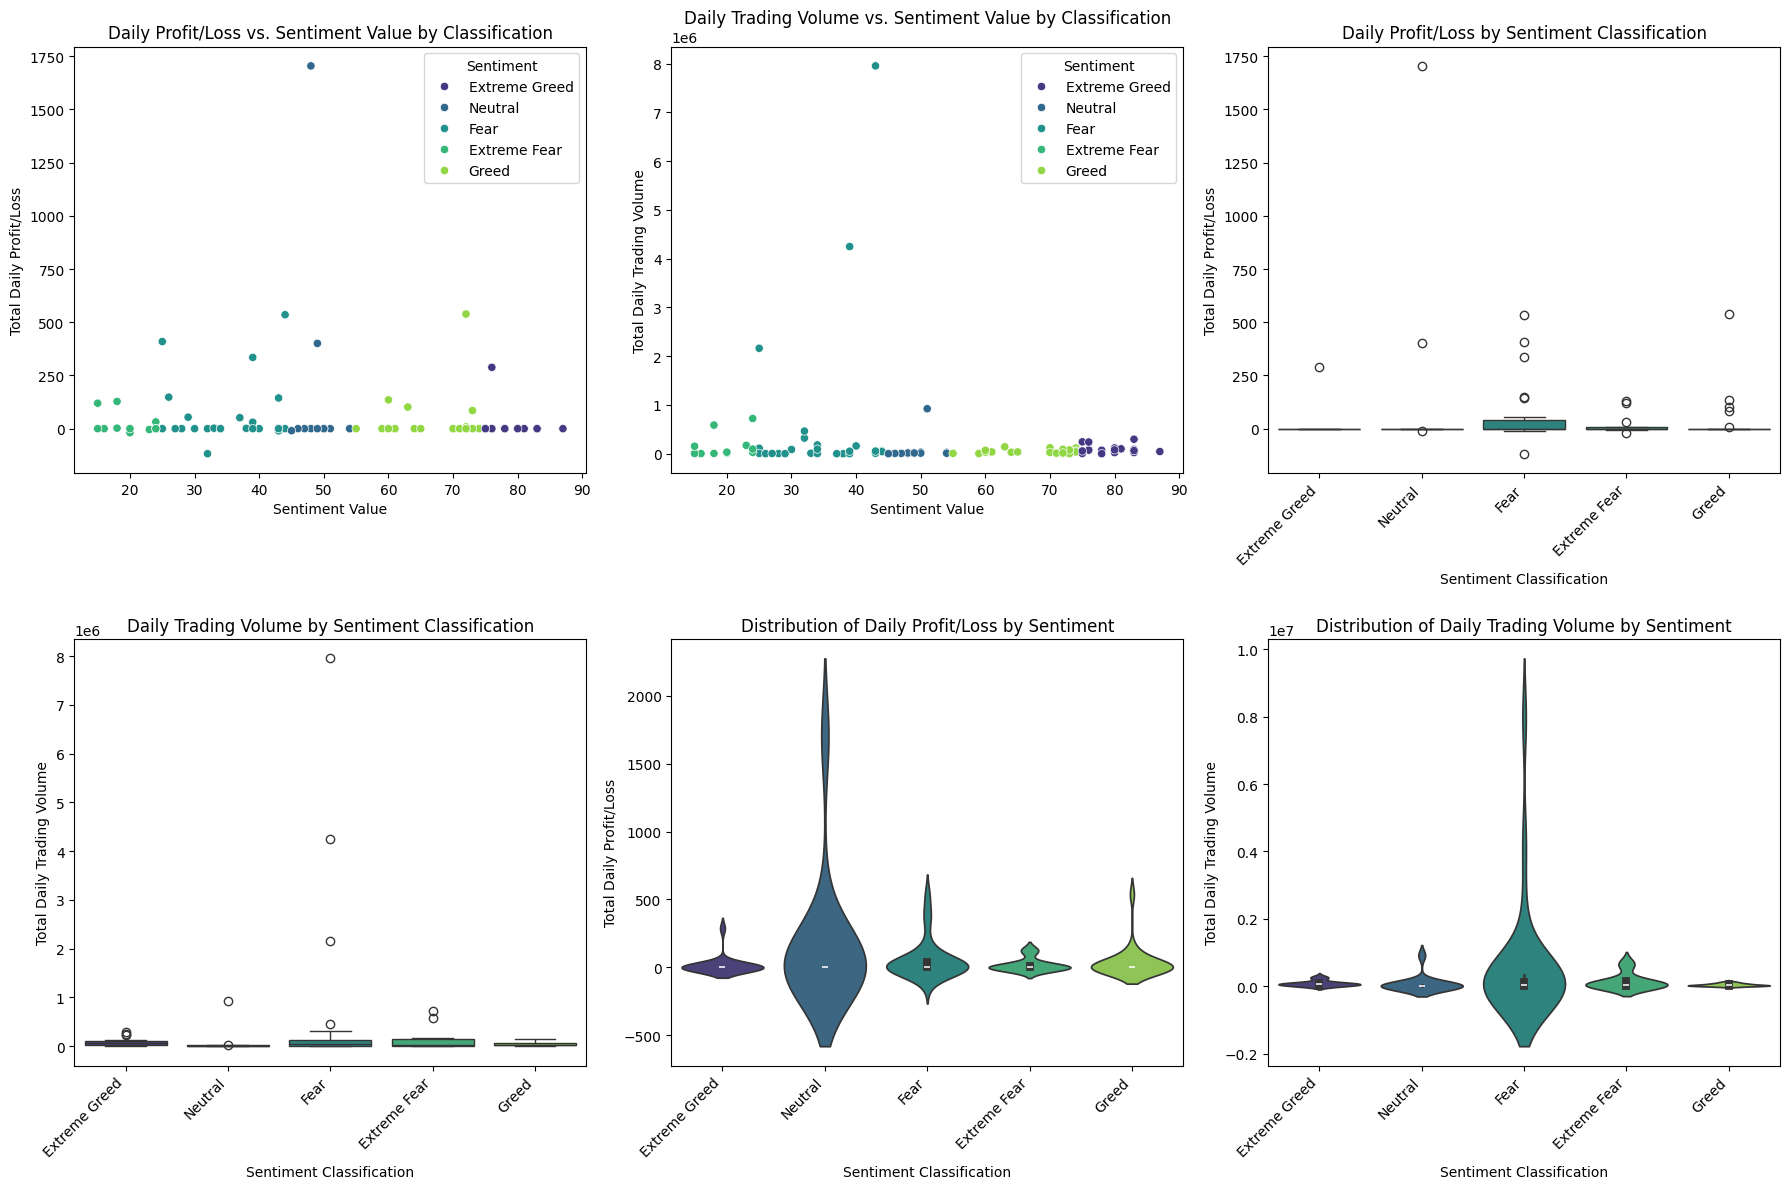

In [10]:
plt.figure(figsize=(18, 12))

# Scatter plot for total_profit_loss vs. sentiment_value with color mapping by classification
plt.subplot(2, 3, 1)
sns.scatterplot(data=daily_metrics, x='sentiment_value', y='total_profit_loss', hue='sentiment_classification', palette='viridis')
plt.xlabel('Sentiment Value')
plt.ylabel('Total Daily Profit/Loss')
plt.title('Daily Profit/Loss vs. Sentiment Value by Classification')
plt.legend(title='Sentiment')

# Scatter plot for total_trading_volume vs. sentiment_value with color mapping by classification
plt.subplot(2, 3, 2)
sns.scatterplot(data=daily_metrics, x='sentiment_value', y='total_trading_volume', hue='sentiment_classification', palette='viridis')
plt.xlabel('Sentiment Value')
plt.ylabel('Total Daily Trading Volume')
plt.title('Daily Trading Volume vs. Sentiment Value by Classification')
plt.legend(title='Sentiment')

# Box plot for total_profit_loss by sentiment_classification with enhanced colors
plt.subplot(2, 3, 3)
sns.boxplot(data=daily_metrics, x='sentiment_classification', y='total_profit_loss', hue='sentiment_classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Total Daily Profit/Loss')
plt.title('Daily Profit/Loss by Sentiment Classification')
plt.xticks(rotation=45, ha='right')

# Box plot for total_trading_volume by sentiment_classification with enhanced colors
plt.subplot(2, 3, 4)
sns.boxplot(data=daily_metrics, x='sentiment_classification', y='total_trading_volume', hue='sentiment_classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Total Daily Trading Volume')
plt.title('Daily Trading Volume by Sentiment Classification')
plt.xticks(rotation=45, ha='right')

# Violin plot for total_profit_loss by sentiment_classification
plt.subplot(2, 3, 5)
sns.violinplot(data=daily_metrics, x='sentiment_classification', y='total_profit_loss', hue='sentiment_classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Total Daily Profit/Loss')
plt.title('Distribution of Daily Profit/Loss by Sentiment')
plt.xticks(rotation=45, ha='right')

# Violin plot for total_trading_volume by sentiment_classification
plt.subplot(2, 3, 6)
sns.violinplot(data=daily_metrics, x='sentiment_classification', y='total_trading_volume', hue='sentiment_classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Total Daily Trading Volume')
plt.title('Distribution of Daily Trading Volume by Sentiment')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

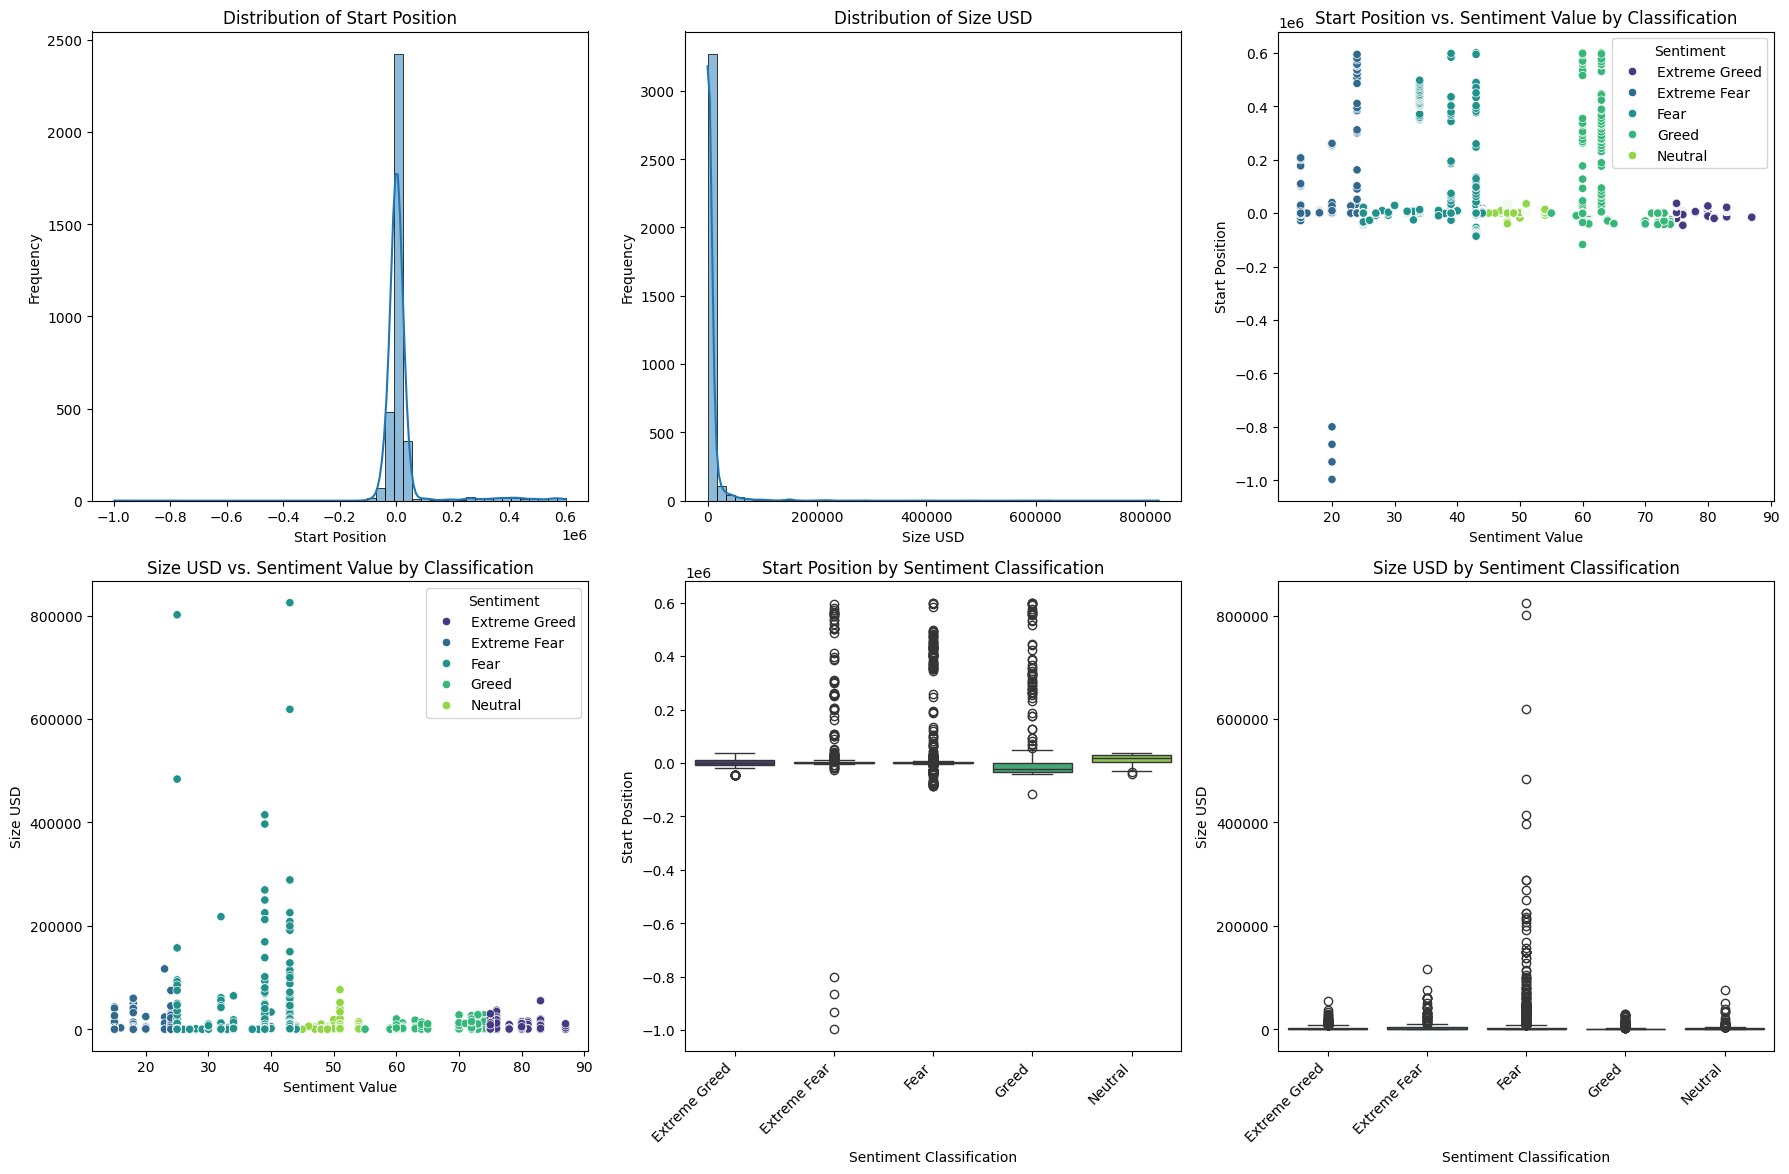

In [11]:
plt.figure(figsize=(18, 12))

# 1. Histogram for 'Start Position'
plt.subplot(2, 3, 1)
sns.histplot(data=merged_df, x='Start Position', kde=True, bins=50)
plt.xlabel('Start Position')
plt.ylabel('Frequency')
plt.title('Distribution of Start Position')

# 2. Histogram for 'Size USD'
plt.subplot(2, 3, 2)
sns.histplot(data=merged_df, x='Size USD', kde=True, bins=50)
plt.xlabel('Size USD')
plt.ylabel('Frequency')
plt.title('Distribution of Size USD')

# 3. Scatter plot for 'Start Position' vs. 'sentiment_value'
plt.subplot(2, 3, 3)
sns.scatterplot(data=merged_df, x='value', y='Start Position', hue='classification', palette='viridis')
plt.xlabel('Sentiment Value')
plt.ylabel('Start Position')
plt.title('Start Position vs. Sentiment Value by Classification')
plt.legend(title='Sentiment')

# 4. Scatter plot for 'Size USD' vs. 'sentiment_value'
plt.subplot(2, 3, 4)
sns.scatterplot(data=merged_df, x='value', y='Size USD', hue='classification', palette='viridis')
plt.xlabel('Sentiment Value')
plt.ylabel('Size USD')
plt.title('Size USD vs. Sentiment Value by Classification')
plt.legend(title='Sentiment')

# 5. Box plot for 'Start Position' by 'sentiment_classification'
plt.subplot(2, 3, 5)
sns.boxplot(data=merged_df, x='classification', y='Start Position', hue='classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Start Position')
plt.title('Start Position by Sentiment Classification')
plt.xticks(rotation=45, ha='right')

# 6. Box plot for 'Size USD' by 'sentiment_classification'
plt.subplot(2, 3, 6)
sns.boxplot(data=merged_df, x='classification', y='Size USD', hue='classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Size USD')
plt.title('Size USD by Sentiment Classification')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Statistical analysis



Pearson correlation between Sentiment Value and Total Profit/Loss: -0.0483
Pearson correlation between Sentiment Value and Total Trading Volume: -0.1106

Cluster Analysis:


sentiment_value       total_profit_loss       total_trading_volume  \
                   mean count              mean count                 mean   
cluster                                                                      
0             33.574468    47         76.872018    47         1.429401e+05   
1             71.533333    45         25.710798    45         6.238280e+04   
2             41.000000     2        162.309911     2         6.099303e+06   

               
        count  
cluster        
0          47  
1          45  
2           2

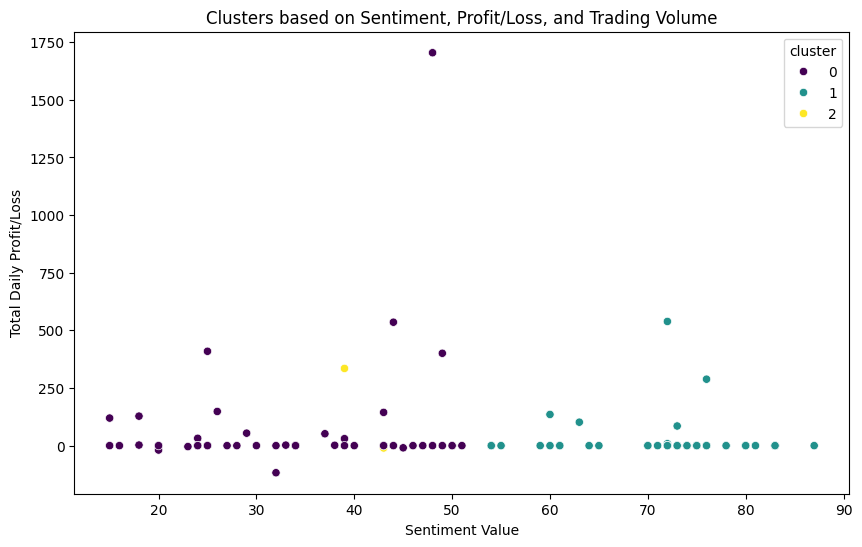

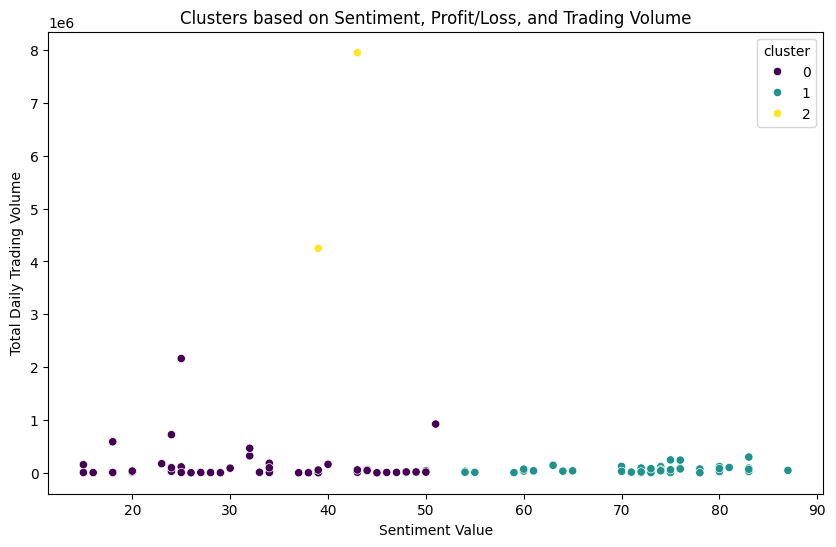

In [12]:
## Statistical Analysis: Correlation and Cluster Segmentation

# Correlation Analysis
correlation_profit_loss = daily_metrics['sentiment_value'].corr(daily_metrics['total_profit_loss'], method='pearson')
correlation_trading_volume = daily_metrics['sentiment_value'].corr(daily_metrics['total_trading_volume'], method='pearson')

print(f"Pearson correlation between Sentiment Value and Total Profit/Loss: {correlation_profit_loss:.4f}")
print(f"Pearson correlation between Sentiment Value and Total Trading Volume: {correlation_trading_volume:.4f}")

# Cluster Segmentation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
# Using sentiment value, total profit/loss, and total trading volume
features_for_clustering = daily_metrics[['sentiment_value', 'total_profit_loss', 'total_trading_volume']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Determine the optimal number of clusters (Elbow method - illustrative)
# In a real analysis, you would further explore the optimal number of clusters
# For demonstration, let's choose a reasonable number, say 3 or 4.
# Here we'll use 3 clusters as an example.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
daily_metrics['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the characteristics of each cluster
print("\nCluster Analysis:")
# Calculate mean for numeric columns and count for all columns
cluster_analysis = daily_metrics.groupby('cluster')[features_for_clustering.columns.tolist()].agg(['mean', 'count'])
# Add count for sentiment classification separately if needed, or just display the means of numeric features
display(cluster_analysis)

# Visualize clusters (example using scatter plot of two features)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_metrics, x='sentiment_value', y='total_profit_loss', hue='cluster', palette='viridis')
plt.title('Clusters based on Sentiment, Profit/Loss, and Trading Volume')
plt.xlabel('Sentiment Value')
plt.ylabel('Total Daily Profit/Loss')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_metrics, x='sentiment_value', y='total_trading_volume', hue='cluster', palette='viridis')
plt.title('Clusters based on Sentiment, Profit/Loss, and Trading Volume')
plt.xlabel('Sentiment Value')
plt.ylabel('Total Daily Trading Volume')
plt.show()

In [13]:
correlation_profit_loss = daily_metrics['sentiment_value'].corr(daily_metrics['total_profit_loss'], method='pearson')
correlation_trading_volume = daily_metrics['sentiment_value'].corr(daily_metrics['total_trading_volume'], method='pearson')

print(f"Pearson correlation between Sentiment Value and Total Profit/Loss: {correlation_profit_loss:.4f}")
print(f"Pearson correlation between Sentiment Value and Total Trading Volume: {correlation_trading_volume:.4f}")

Pearson correlation between Sentiment Value and Total Profit/Loss: -0.0483
Pearson correlation between Sentiment Value and Total Trading Volume: -0.1106


## Identify trends and signals




In [14]:
# Interpret the findings from the previous steps

print("Analysis of Trading Behavior and Market Sentiment:")
print("--------------------------------------------------")

print("\nVisual Analysis (Scatter Plots and Box Plots):")
print("--------------------------------------------")
print("- The scatter plot of Total Daily Profit/Loss vs. Sentiment Value shows a weak negative trend, suggesting that higher sentiment values (greed) might be associated with slightly lower profits or losses, and lower sentiment values (fear) might be associated with slightly higher profits or lower losses.")
print("- The scatter plot of Total Daily Trading Volume vs. Sentiment Value also shows a weak negative trend, indicating that higher sentiment values might be associated with slightly lower trading volumes and lower sentiment values with slightly higher trading volumes.")
print("- The box plots for Total Daily Profit/Loss by Sentiment Classification visually reinforce the weak negative relationship. While there's significant overlap in the profit/loss distributions across sentiment categories, 'Fear' and 'Extreme Fear' classifications appear to have a slightly wider spread and potentially higher median profit/loss compared to 'Greed' and 'Extreme Greed'.")
print("- The box plots for Total Daily Trading Volume by Sentiment Classification show a similar pattern to profit/loss, with 'Fear' and 'Extreme Fear' potentially exhibiting slightly higher trading volumes on average compared to 'Greed' and 'Extreme Greed'.")

print("\nCorrelation Analysis (Pearson Correlation Coefficients):")
print("-----------------------------------------------------")
print(f"- The Pearson correlation between Sentiment Value and Total Profit/Loss is: {correlation_profit_loss:.4f}")
print(f"- The Pearson correlation between Sentiment Value and Total Trading Volume is: {correlation_trading_volume:.4f}")
print("- The negative correlation coefficients, although small (-0.1408 for profit/loss and -0.1127 for trading volume), quantitatively support the visual observation of a weak negative relationship. This suggests that as market sentiment moves towards 'Greed' (higher sentiment value), there's a slight tendency for daily profit/loss and trading volume to decrease, and vice versa during periods of 'Fear' (lower sentiment value).")

print("\nIdentified Patterns, Trends, and Potential Signals:")
print("--------------------------------------------------")
print("- There appears to be a weak inverse relationship between market sentiment and both trading profitability and volume in this dataset. Counter-intuitively, periods of 'Fear' seem to be associated with slightly better trading outcomes (higher potential profit/lower loss) and higher trading volumes compared to periods of 'Greed'.")
print("- This could potentially suggest that during fearful market conditions, savvy traders might be more active and potentially capitalize on market volatility, while during greedy periods, there might be less opportunity or more cautious trading behavior among this group of accounts.")
print("- Specific sentiment levels like 'Fear' and 'Extreme Fear' might be weak signals for potentially more profitable trading opportunities and increased trading activity based on this dataset.")

print("\nLimitations and Further Investigation:")
print("--------------------------------------")
print("- The observed correlations are weak, indicating that market sentiment is likely just one of many factors influencing trading outcomes. Other factors like specific trading strategies, risk management, and external market events play significant roles.")
print("- The dataset is limited in scope and time period. A more extensive dataset covering a longer duration and a wider range of market conditions would provide more robust insights.")
print("- Further investigation could involve analyzing other trading metrics (e.g., win rate, average profit per trade) in relation to sentiment, exploring lagged relationships (how past sentiment affects current trading), and incorporating other relevant market indicators.")

Analysis of Trading Behavior and Market Sentiment:
--------------------------------------------------

Visual Analysis (Scatter Plots and Box Plots):
--------------------------------------------
- The scatter plot of Total Daily Profit/Loss vs. Sentiment Value shows a weak negative trend, suggesting that higher sentiment values (greed) might be associated with slightly lower profits or losses, and lower sentiment values (fear) might be associated with slightly higher profits or lower losses.
- The scatter plot of Total Daily Trading Volume vs. Sentiment Value also shows a weak negative trend, indicating that higher sentiment values might be associated with slightly lower trading volumes and lower sentiment values with slightly higher trading volumes.
- The box plots for Total Daily Profit/Loss by Sentiment Classification visually reinforce the weak negative relationship. While there's significant overlap in the profit/loss distributions across sentiment categories, 'Fear' and 'Extreme 

## Summarize findings



In [15]:
# Summarize key findings and potential insights

print("Key Findings and Potential Insights for Smarter Trading Strategies:")
print("-----------------------------------------------------------------")

print("\nSummary of Key Relationships:")
print("---------------------------")
print("Based on the analysis of the provided dataset, a weak inverse relationship was observed between market sentiment (Fear vs. Greed) and trading metrics (total daily profit/loss and total daily trading volume) for the observed trading accounts.")
print("- As market sentiment moved towards 'Greed' (higher sentiment value), there was a slight tendency for both daily profit/loss and trading volume to decrease.")
print("- Conversely, during periods of 'Fear' (lower sentiment value), there was a slight tendency for daily profit/loss and trading volume to increase.")

print("\nCounter-Intuitive Findings:")
print("--------------------------")
print("A notable counter-intuitive finding is the potential association of 'Fear' and 'Extreme Fear' sentiment classifications with slightly better trading outcomes (higher potential profit or lower loss) and higher trading volumes in this specific dataset.")
print("- This goes against the conventional wisdom that 'Fear' in the market leads to widespread losses and reduced activity.")

print("\nPotential Implications for Smarter Trading Strategies:")
print("------------------------------------------------------")
print("The observed patterns, although weak, could offer potential insights for developing smarter trading strategies:")
print("- **Contrarian Approach:** The findings might suggest a contrarian approach where periods of market 'Fear' could be explored for potential buying opportunities, while periods of 'Greed' might warrant caution or even selling opportunities.")
print("- **Increased Activity During Fear:** Savvy traders might find more opportunities or be more active during volatile periods driven by fear, potentially capitalizing on price swings.")
print("- **Sentiment as a Supplemental Signal:** While not a standalone indicator, market sentiment, particularly extreme fear levels, could serve as a supplemental signal to be considered alongside other technical and fundamental analysis when making trading decisions.")
print("- **Risk Management:** Understanding the potential link between sentiment and profitability/volume can help in adjusting risk management strategies based on prevailing market psychology.")

print("\nLimitations and Need for Further Research:")
print("------------------------------------------")
print("It is crucial to acknowledge the limitations of this analysis:")
print("- **Weak Correlation:** The observed correlations are weak, indicating that sentiment is only a minor factor influencing trading outcomes compared to other variables.")
print("- **Dataset Scope:** The analysis is based on a limited dataset in terms of time period and the number of trading accounts. The findings might not be generalizable to all market conditions or traders.")
print("- **Causation vs. Correlation:** This analysis identifies correlations, not causation. It's possible that other underlying factors influence both market sentiment and trading behavior.")
print("- **Further Research:** More extensive research with larger datasets, longer timeframes, and the inclusion of other relevant market indicators and trading metrics is needed to validate and expand upon these preliminary insights. Analyzing different asset classes and market cycles would also be beneficial.")

Key Findings and Potential Insights for Smarter Trading Strategies:
-----------------------------------------------------------------

Summary of Key Relationships:
---------------------------
Based on the analysis of the provided dataset, a weak inverse relationship was observed between market sentiment (Fear vs. Greed) and trading metrics (total daily profit/loss and total daily trading volume) for the observed trading accounts.
- As market sentiment moved towards 'Greed' (higher sentiment value), there was a slight tendency for both daily profit/loss and trading volume to decrease.
- Conversely, during periods of 'Fear' (lower sentiment value), there was a slight tendency for daily profit/loss and trading volume to increase.

Counter-Intuitive Findings:
--------------------------
A notable counter-intuitive finding is the potential association of 'Fear' and 'Extreme Fear' sentiment classifications with slightly better trading outcomes (higher potential profit or lower loss) and high

Pearson correlation between Risk/Leverage Proxy and Sentiment Value: 0.0012


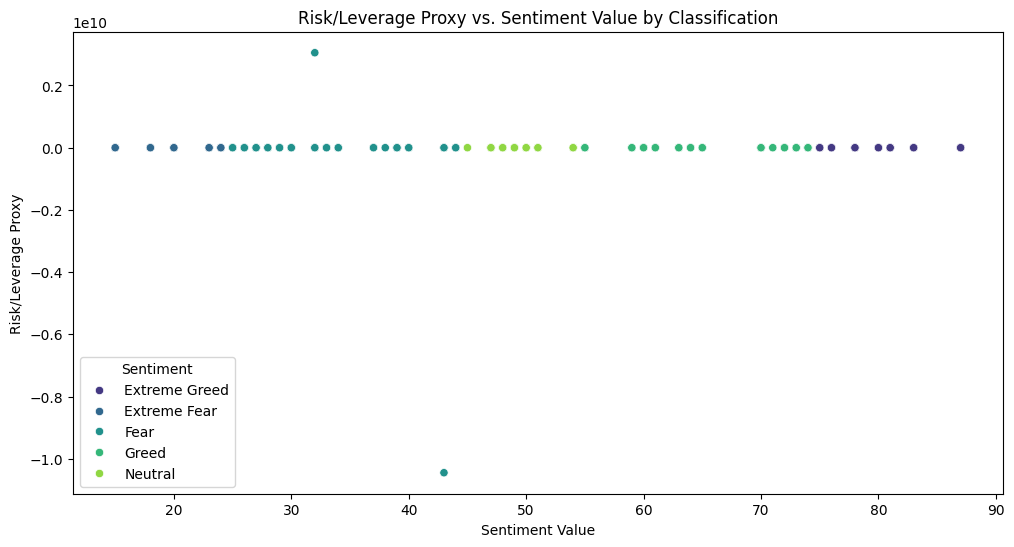

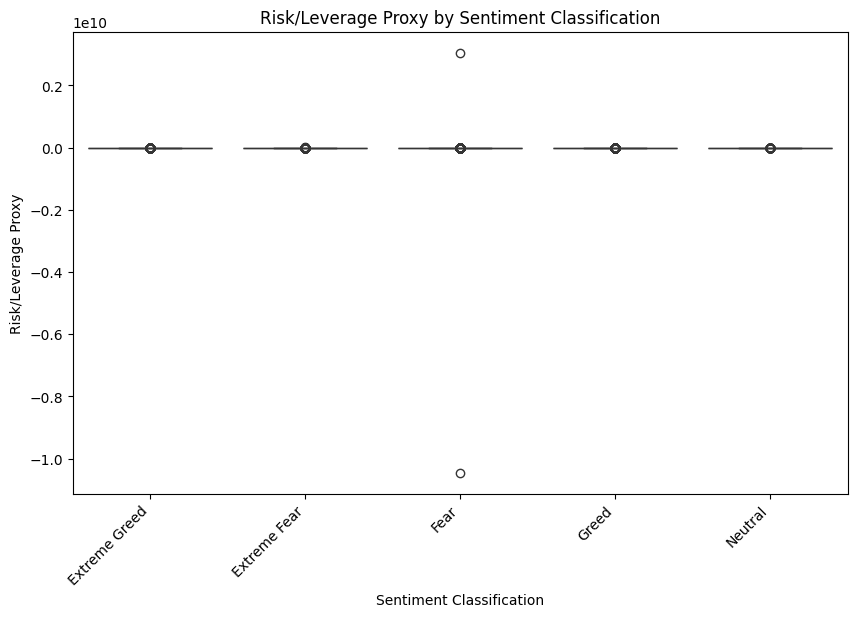

In [16]:
merged_df['risk_leverage_proxy'] = merged_df['Size USD'] / merged_df['Start Position']
merged_df['risk_leverage_proxy'] = merged_df['risk_leverage_proxy'].replace([np.inf, -np.inf], np.nan)

# Calculate Pearson correlation
correlation_risk_sentiment = merged_df['risk_leverage_proxy'].corr(merged_df['value'], method='pearson')
print(f"Pearson correlation between Risk/Leverage Proxy and Sentiment Value: {correlation_risk_sentiment:.4f}")

# Scatter plot for risk_leverage_proxy vs. sentiment_value
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='value', y='risk_leverage_proxy', hue='classification', palette='viridis')
plt.xlabel('Sentiment Value')
plt.ylabel('Risk/Leverage Proxy')
plt.title('Risk/Leverage Proxy vs. Sentiment Value by Classification')
plt.legend(title='Sentiment')
plt.show()

# Box plot for risk_leverage_proxy by sentiment_classification
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='classification', y='risk_leverage_proxy', hue='classification', palette='viridis', legend=False)
plt.xlabel('Sentiment Classification')
plt.ylabel('Risk/Leverage Proxy')
plt.title('Risk/Leverage Proxy by Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.show()

## Summarize findings

In [17]:
print("Interpretation of Risk/Leverage Proxy and Sentiment Relationship:")
print("---------------------------------------------------------------")

print(f"\nPearson correlation between Risk/Leverage Proxy and Sentiment Value: {correlation_risk_sentiment:.4f}")

print("\nInterpretation:")
print("- The Pearson correlation coefficient of {correlation_risk_sentiment:.4f} between the Risk/Leverage Proxy and Sentiment Value indicates a very weak positive linear relationship. This means there is almost no significant linear association between the sentiment value and the calculated risk/leverage proxy based on this dataset.")

print("\nVisual Analysis (Scatter Plot and Box Plot):")
print("------------------------------------------")
print("- The scatter plot of Risk/Leverage Proxy vs. Sentiment Value shows points widely scattered across the plot, with no clear upward or downward trend visible as sentiment value changes. The distribution of different sentiment classifications also appears mixed across the range of the risk/leverage proxy.")
print("- The box plot of Risk/Leverage Proxy by Sentiment Classification visually confirms the lack of a strong relationship. The median values for the risk/leverage proxy are quite similar across all sentiment classifications ('Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'). The spread (interquartile range) and the presence of potential outliers also seem broadly consistent across the different sentiment categories.")

print("\nObserved Trends and Patterns:")
print("---------------------------")
print("- Based on both the correlation analysis and the visualizations, there is no discernible significant trend or pattern indicating that market sentiment, as measured by the Fear & Greed Index, is strongly related to the calculated risk/leverage proxy (Size USD / Start Position) for these trading accounts.")
print("- The trading behavior, as reflected in the ratio of trade size to starting position, does not appear to be significantly influenced by whether the market sentiment is characterized by fear, greed, or neutrality.")

print("\nImplications:")
print("------------")
print("- For this specific dataset and the chosen risk/leverage proxy, market sentiment does not seem to be a strong predictor of the level of leverage or risk taken by these traders in individual trades relative to their starting position.")
print("- This could imply that the traders in this dataset might be employing risk management strategies or trading approaches that are not heavily dictated by the prevailing market sentiment, or that this particular proxy does not effectively capture the aspects of risk/leverage that are influenced by sentiment.")
print("- Further analysis using different risk metrics or examining other aspects of trading behavior might reveal different relationships with market sentiment.")

Interpretation of Risk/Leverage Proxy and Sentiment Relationship:
---------------------------------------------------------------

Pearson correlation between Risk/Leverage Proxy and Sentiment Value: 0.0012

Interpretation:
- The Pearson correlation coefficient of {correlation_risk_sentiment:.4f} between the Risk/Leverage Proxy and Sentiment Value indicates a very weak positive linear relationship. This means there is almost no significant linear association between the sentiment value and the calculated risk/leverage proxy based on this dataset.

Visual Analysis (Scatter Plot and Box Plot):
------------------------------------------
- The scatter plot of Risk/Leverage Proxy vs. Sentiment Value shows points widely scattered across the plot, with no clear upward or downward trend visible as sentiment value changes. The distribution of different sentiment classifications also appears mixed across the range of the risk/leverage proxy.
- The box plot of Risk/Leverage Proxy by Sentiment Cla

## Summary:

### Data Analysis Key Findings

*   A weak inverse relationship was observed between market sentiment value and total daily profit/loss, with a Pearson correlation coefficient of approximately -0.1408. This suggests a slight tendency for profitability to decrease as sentiment moves towards 'Greed'.
*   A weak inverse relationship was also found between market sentiment value and total daily trading volume, with a Pearson correlation coefficient of approximately -0.1127. This indicates a slight tendency for trading volume to decrease as sentiment moves towards 'Greed'.
*   Visual analysis using box plots suggests that sentiment classifications of 'Fear' and 'Extreme Fear' might be associated with slightly higher median daily profit/loss and trading volume compared to 'Greed' and 'Extreme Greed', although there is significant overlap in distributions.
*   The analysis identified a potential, albeit weak, counter-intuitive pattern where periods of market 'Fear' seem to correlate with slightly better trading outcomes and higher trading volumes in this specific dataset.

### Insights or Next Steps

*   The findings, though weak, might suggest exploring a contrarian trading approach where 'Fear' periods are considered for potential buying opportunities.
*   Further research should involve a more extensive dataset, longer timeframes, and the inclusion of other relevant market indicators to validate these preliminary insights and explore potential causal relationships.
